## Working with Transformers in the HuggingFace Ecosystem

In this laboratory exercise we will learn how to work with the HuggingFace ecosystem to adapt models to new tasks. As you will see, much of what is required is *investigation* into the inner-workings of the HuggingFace abstractions. With a little work, a little trial-and-error, it is fairly easy to get a working adaptation pipeline up and running.

#### Exercise 1.1


In [47]:
from datasets import load_dataset, get_dataset_split_names
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm
from sklearn.svm import LinearSVC
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
import pandas as pd
from transformers import CLIPProcessor, CLIPModel
import random
import os
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
dataset = load_dataset("cornell-movie-review-data/rotten_tomatoes")

splits = get_dataset_split_names("cornell-movie-review-data/rotten_tomatoes")
print("Splits:", splits)

Splits: ['train', 'validation', 'test']


In [3]:
print("Train size:", len(dataset["train"]))
print("Validation size:", len(dataset["validation"]))
print("Test size:", len(dataset["test"]))

Train size: 8530
Validation size: 1066
Test size: 1066


In [4]:
print("Example:\n", dataset["train"][211])

Example:
 {'text': '[a] rare , beautiful film .', 'label': 1}


#### Exercise 1.2

In [5]:
name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(name)
model = AutoModel.from_pretrained(name)

sample = dataset["test"]["text"][260]
print(sample)

encoded_input = tokenizer(sample, return_tensors="pt")
print(encoded_input)

intensely romantic , thought-provoking and even an engaging mystery .
{'input_ids': tensor([[  101, 20531,  6298,  1010,  2245,  1011,  4013, 22776,  1998,  2130,
          2019, 11973,  6547,  1012,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [6]:
output = model(**encoded_input)
print(output)

BaseModelOutput(last_hidden_state=tensor([[[-0.2474, -0.2550, -0.1434,  ..., -0.2345,  0.4026,  0.1096],
         [-0.0094,  0.2953,  0.0051,  ..., -0.3797,  0.2477, -0.3513],
         [-0.2699,  0.1544,  0.3303,  ..., -0.5992,  0.1053, -0.4761],
         ...,
         [-0.1478, -0.0413,  0.4556,  ..., -0.2515,  0.2923, -0.3443],
         [-0.5207, -0.7747, -0.1066,  ...,  0.3429,  0.4019, -0.4375],
         [ 0.9744, -0.0602, -0.1639,  ..., -0.0061, -0.3364, -0.0374]]],
       grad_fn=<NativeLayerNormBackward0>), hidden_states=None, attentions=None)


In [7]:
print("\nLast hidden state shape:", output.last_hidden_state.shape)


Last hidden state shape: torch.Size([1, 15, 768])


In [8]:
sample = dataset["test"]["text"][29]
print(sample)

encoded_input = tokenizer(sample, return_tensors="pt")

output = model(**encoded_input)
print("\nLast hidden state shape:", output.last_hidden_state.shape)

a soul-stirring documentary about the israeli/palestinian conflict as revealed through the eyes of some children who remain curious about each other against all odds .

Last hidden state shape: torch.Size([1, 31, 768])


#### Exercise 1.3: A Stable Baseline

In [9]:
sample = "i want to see if [CLS] is at the beginning or at the end of the sequence"
encoded = tokenizer(sample, return_tensors="pt")

print("Token IDs:", encoded["input_ids"])
print("Decoded tokens:", tokenizer.convert_ids_to_tokens(encoded["input_ids"][0]))

Token IDs: tensor([[ 101, 1045, 2215, 2000, 2156, 2065,  101, 2003, 2012, 1996, 2927, 2030,
         2012, 1996, 2203, 1997, 1996, 5537,  102]])
Decoded tokens: ['[CLS]', 'i', 'want', 'to', 'see', 'if', '[CLS]', 'is', 'at', 'the', 'beginning', 'or', 'at', 'the', 'end', 'of', 'the', 'sequence', '[SEP]']


#### So the [CLS] is the first element of the output sequence!

In [10]:
def extract_features(texts, tokenizer, model, device="cuda"):
    model = model.to(device)
    model.eval()  

    hidden_size = 768  
    features = torch.zeros((len(texts), hidden_size))

    with torch.no_grad():  
        for i, text in enumerate(tqdm(texts, desc="Extracting features")):
            encoded = tokenizer(text, return_tensors="pt").to(device)

            output = model(**encoded)

            cls_vec = output.last_hidden_state[:, 0, :] 

            features[i, :] = cls_vec.cpu()

    return features


In [11]:
text_train = extract_features(dataset["train"]["text"], tokenizer, model)
labels_train = dataset["train"]["label"]

text_validation = extract_features(dataset["validation"]["text"], tokenizer, model)
labels_validation = dataset["validation"]["label"]

text_test = extract_features(dataset["test"]["text"], tokenizer, model)
labels_test = dataset["test"]["label"]


Extracting features: 100%|██████████| 1066/1066 [00:08<00:00, 126.44it/s]


In [12]:
clf = LinearSVC()
clf.fit(text_train, labels_train)

validation_predictions = clf.predict(text_validation)
test_predictions = clf.predict(text_test)

print(f"Validation accuracy: {accuracy_score(labels_validation, validation_predictions):.3f}")
print(f"Test accuracy: {accuracy_score(labels_test, test_predictions):.3f}")

Validation accuracy: 0.822
Test accuracy: 0.798


-----
### Exercise 2: Fine-tuning Distilbert

#### Exercise 2.1: Token Preprocessing

In [13]:
def tokenize(dataset_element):
    encoded = tokenizer(dataset_element["text"])

    return {
        "text": dataset_element["text"],
        "label": dataset_element["label"],
        "input_ids": encoded["input_ids"],
        "attention_mask": encoded["attention_mask"],
    }

In [14]:
tokenized_train = dataset["train"].map(tokenize)
tokenized_val = dataset["validation"].map(tokenize)
tokenized_test = dataset["test"].map(tokenize)

In [15]:
print(tokenized_test[29])

{'text': 'a soul-stirring documentary about the israeli/palestinian conflict as revealed through the eyes of some children who remain curious about each other against all odds .', 'label': 1, 'input_ids': [101, 1037, 3969, 1011, 18385, 4516, 2055, 1996, 5611, 1013, 9302, 4736, 2004, 3936, 2083, 1996, 2159, 1997, 2070, 2336, 2040, 3961, 8025, 2055, 2169, 2060, 2114, 2035, 10238, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


#### Exercise 2.2: Setting up the Model to be Fine-tuned

In this exercise we need to prepare the base Distilbert model for fine-tuning for a *sequence classification task*. This means, at the very least, appending a new, randomly-initialized classification head connected to the `[CLS]` token of the last transformer layer. Luckily, HuggingFace already provides an `AutoModel` for just this type of instantiation: [`AutoModelForSequenceClassification`](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#automodelforsequenceclassification). You will want you instantiate one of these for fine-tuning.

In [16]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Exercise 2.3: Fine-tuning Distilbert

Finally. In this exercise you should use a HuggingFace [`Trainer`](https://huggingface.co/docs/transformers/main/en/trainer) to fine-tune your model on the Rotten Tomatoes training split. Setting up the trainer will involve (at least):


1. Instantiating a [`DataCollatorWithPadding`](https://huggingface.co/docs/transformers/en/main_classes/data_collator) object which is what *actually* does your batch construction (by padding all sequences to the same length).
2. Writing an *evaluation function* that will measure the classification accuracy. This function takes a single argument which is a tuple containing `(logits, labels)` which you should use to compute classification accuracy (and maybe other metrics like F1 score, precision, recall) and return a `dict` with these metrics.  
3. Instantiating a [`TrainingArguments`](https://huggingface.co/docs/transformers/v4.51.1/en/main_classes/trainer#transformers.TrainingArguments) object using some reasonable defaults.
4. Instantiating a `Trainer` object using your train and validation splits, you data collator, and function to compute performance metrics.
5. Calling `trainer.train()`, waiting, waiting some more, and then calling `trainer.evaluate()` to see how it did.

**Tip**: When prototyping this laboratory I discovered the HuggingFace [Evaluate library](https://huggingface.co/docs/evaluate/en/index) which provides evaluation metrics. However I found it to have insufferable layers of abstraction and getting actual metrics computed. I suggest just using the Scikit-learn metrics...

In [57]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)  
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


In [58]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


training_args = TrainingArguments(
    output_dir="./output",
    logging_dir="./logs",
    eval_strategy="epoch",      
    save_strategy="epoch",  
    save_total_limit=1,           
    load_best_model_at_end=True,   
    metric_for_best_model="accuracy",
    greater_is_better=True,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=30,
    logging_strategy="epoch" 
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

PyTorch: setting up devices
average_tokens_across_devices is True but world size is 1. Setting it to False automatically.
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the Training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 8,530
  Num Epochs = 30
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 4,020
  Number of trainable parameters = 66,955,010


Epoch,Training Loss,Validation Loss


The following columns in the Evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1066
  Batch size = 64
Saving model checkpoint to ./results\checkpoint-134
Configuration saved in ./results\checkpoint-134\config.json
Model weights saved in ./results\checkpoint-134\model.safetensors
tokenizer config file saved in ./results\checkpoint-134\tokenizer_config.json
Special tokens file saved in ./results\checkpoint-134\special_tokens_map.json
The following columns in the Evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1066


TrainOutput(global_step=4020, training_loss=0.0009202774501549112, metrics={'train_runtime': 3209.7005, 'train_samples_per_second': 79.727, 'train_steps_per_second': 1.252, 'total_flos': 3698470624796808.0, 'train_loss': 0.0009202774501549112, 'epoch': 30.0})

In [62]:
results = trainer.evaluate()

df_results = pd.DataFrame([results])
df_results

The following columns in the Evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1066
  Batch size = 64


,eval_loss,eval_accuracy,eval_precision,eval_recall,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,1.55037,0.847092,0.855769,0.834897,0.845204,2.9078,366.598,5.846,30.0


#### Exercise 3.2: Fine-tuning a CLIP Model (harder)

Use a (small) CLIP model like [`openai/clip-vit-base-patch16`](https://huggingface.co/openai/clip-vit-base-patch16) and evaluate its zero-shot performance on a small image classification dataset like ImageNette or TinyImageNet. Fine-tune (using a parameter-efficient method!) the CLIP model to see how much improvement you can squeeze out of it.

**Note**: There are several ways to adapt the CLIP model; you could fine-tune the image encoder, the text encoder, or both. Or, you could experiment with prompt learning.

**Tip**: CLIP probably already works very well on ImageNet and ImageNet-like images. For extra fun, look for an image classification dataset with different image types (e.g. *sketches*).

In [13]:
dataset = load_dataset("zh-plus/tiny-imagenet", split="valid")

In [44]:
words_file = 'words.txt'  # to map class names into human understandable labels
wnid_to_name = {}

with open(words_file) as f:
    for line in f:
        wnid, name = line.strip().split("\t")
        wnid_to_name[wnid] = name.split(",")[0]  # to take only the first description, example  black widow, Latrodectus mactans -> black widow

idx_to_class_name = {
    i: wnid_to_name[wnid]
    for i, wnid in enumerate(dataset.features["label"].names)
}

for i in range(10):
    print(f"{i}: {idx_to_class_name[i]}")

0: goldfish
1: European fire salamander
2: bullfrog
3: tailed frog
4: American alligator
5: boa constrictor
6: trilobite
7: scorpion
8: black widow
9: tarantula


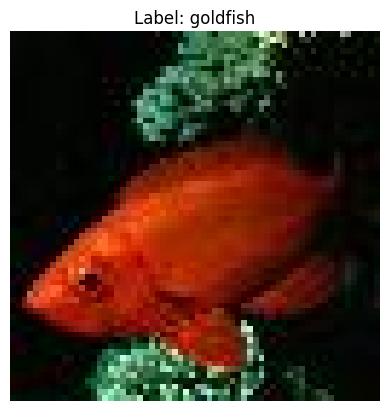

In [45]:
def show_image_with_label(idx, save=False):
    item = dataset[idx]
    image = item["image"]
    label_idx = item["label"]
    label_name = idx_to_class_name.get(label_idx, f"Unknown ({label_idx})")
    
    plt.imshow(image)
    plt.title(f"Label: {label_name}")
    plt.axis('off')
    plt.show()
    
    if save:
        image.save("image.jpg")


show_image_with_label(32)

In [60]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "openai/clip-vit-base-patch16"
model = CLIPModel.from_pretrained(model_name).to(device)
processor = CLIPProcessor.from_pretrained(model_name)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

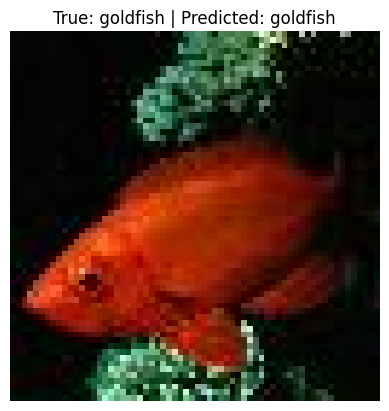


Top-5 predictions:
1: goldfish -> 0.776
2: brain coral -> 0.066
3: coral reef -> 0.055
4: dugong -> 0.013
5: reel -> 0.009


In [71]:
def show_image_with_clip_prediction(idx, topk=5, save=False):
    item = dataset[idx]
    image = item["image"]
    label_idx = item["label"]
    label_name = idx_to_class_name[label_idx]
    

    class_labels = [idx_to_class_name[i] for i in range(len(idx_to_class_name))]
    text_inputs = processor(text=class_labels, return_tensors="pt", padding=True).to(device)
    image_input = processor(images=image, return_tensors="pt").to(device)

    
    with torch.no_grad():
        outputs = model(**image_input, **text_inputs)
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=-1)
        pred_idx = logits_per_image.argmax().item()
    
    plt.imshow(image)
    plt.title(f"True: {label_name} | Predicted: {idx_to_class_name[pred_idx]}")
    plt.axis("off")
    plt.show()
    
    top_probs, top_idx = probs.topk(topk)
    print(f"\nTop-{topk} predictions:")
    for i, (p, j) in enumerate(zip(top_probs[0], top_idx[0])):
        print(f"{i+1}: {idx_to_class_name[j.item()]} -> {p.item():.3f}")
    
    if save:
        image.save("image_pred.jpg")

show_image_with_clip_prediction(32)

In [77]:
n = 50 # number of images to evaluate
seed = 29     

random.seed(seed)
indices = random.sample(range(len(dataset)), n)
subset = [dataset[i] for i in indices]

In [78]:
class_labels = [idx_to_class_name[i] for i in range(len(idx_to_class_name))]
text_inputs = processor(text=class_labels, return_tensors="pt", padding=True).to(device)

In [79]:
correct = 0

for item in tqdm(subset, desc="Zero-shot evaluation"):
    image = processor(images=item["image"], return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**image, **text_inputs)
        logits_per_image = outputs.logits_per_image
        pred_idx = logits_per_image.argmax().item()
    
    if pred_idx == item["label"]:
        correct += 1

accuracy = correct / n
print(f"Zero-shot accuracy on {n} random samples: {accuracy:.4f}")

Zero-shot evaluation: 100%|██████████| 50/50 [00:03<00:00, 15.75it/s]

Zero-shot accuracy on 50 random samples: 0.5600


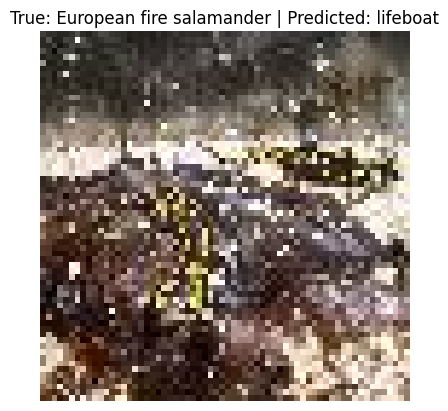


Top-5 predictions:
1: lifeboat -> 0.144
2: projectile -> 0.106
3: freight car -> 0.086
4: space heater -> 0.031
5: beacon -> 0.031



--- Image 1 ---
Label reale: pomegranate (id 179)
Predicted label: pomegranate (id 179)

Top 5 predizioni e probabilità:
1: pomegranate -> 0.8911
2: lemon -> 0.0465
3: iPod -> 0.0184
4: acorn -> 0.0080
5: orange -> 0.0066

Logits raw shape: torch.Size([1, 200])
Max logit value: 29.15721893310547
Min logit value: 12.842262268066406


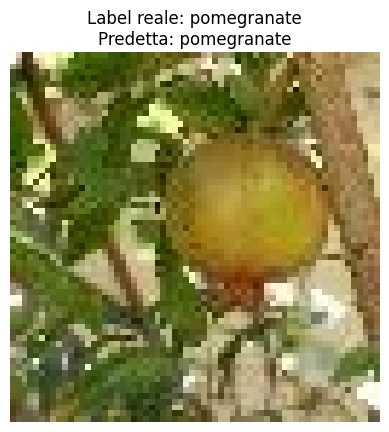


--- Image 2 ---
Label reale: Labrador retriever (id 24)
Predicted label: Labrador retriever (id 24)

Top 5 predizioni e probabilità:
1: Labrador retriever -> 0.8675
2: golden retriever -> 0.0858
3: standard poodle -> 0.0166
4: German shepherd -> 0.0078
5: Yorkshire terrier -> 0.0037

Logits raw shape: torch.Size([1, 200])
Max logit value: 28.12723159790039
Min logit value: 12.071871757507324


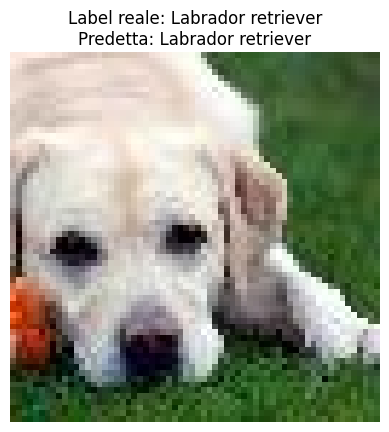


--- Image 3 ---
Label reale: moving van (id 113)
Predicted label: moving van (id 113)

Top 5 predizioni e probabilità:
1: moving van -> 0.8329
2: freight car -> 0.0843
3: police van -> 0.0342
4: limousine -> 0.0137
5: school bus -> 0.0116

Logits raw shape: torch.Size([1, 200])
Max logit value: 27.431415557861328
Min logit value: 10.757328987121582


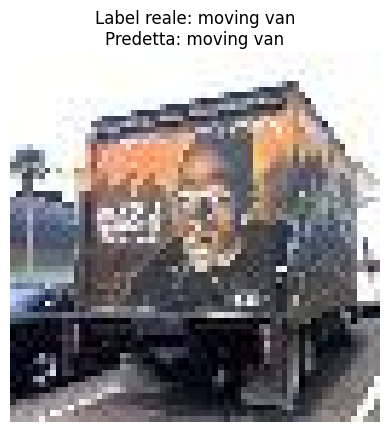


--- Image 4 ---
Label reale: nail (id 196)
Predicted label: confectionery (id 85)

Top 5 predizioni e probabilità:
1: confectionery -> 0.1180
2: projectile -> 0.0659
3: torch -> 0.0581
4: syringe -> 0.0405
5: plunger -> 0.0300

Logits raw shape: torch.Size([1, 200])
Max logit value: 24.399003982543945
Min logit value: 14.984801292419434


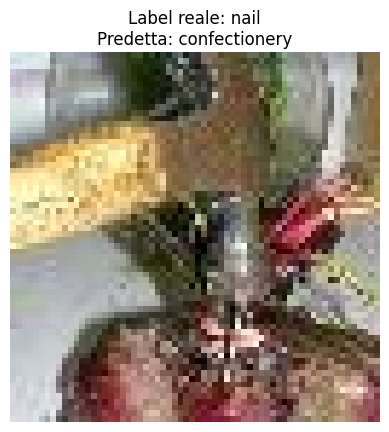


--- Image 5 ---
Label reale: slug (id 198)
Predicted label: banana (id 178)

Top 5 predizioni e probabilità:
1: banana -> 0.2579
2: boa constrictor -> 0.1649
3: European fire salamander -> 0.1454
4: snail -> 0.0603
5: bee -> 0.0283

Logits raw shape: torch.Size([1, 200])
Max logit value: 25.72064781188965
Min logit value: 14.73710823059082


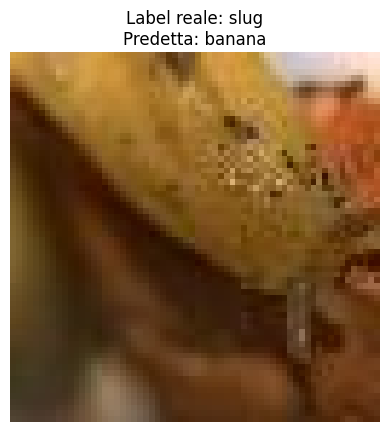

In [58]:
class_labels = [idx_to_class_name[i] for i in range(len(idx_to_class_name))]
prompts = [f"a photo of a {label}" for label in class_labels]
text_inputs = processor(text=prompts, return_tensors="pt", padding=True).to(device)

# -------------------------------
# Zero-shot evaluation con print
# -------------------------------
for idx, item in enumerate(subset):
    print(f"\n--- Image {idx+1} ---")
    image_tensor = processor(images=item["image"], return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model(**image_tensor, **text_inputs)
        logits_per_image = outputs.logits_per_image  # similarità immagine ↔ testo
        probs = logits_per_image.softmax(dim=-1)    # probabilità normalizzate
        
        # indice predetto
        pred_idx = logits_per_image.argmax().item()
    
    # stampa dinamiche interne
    print(f"Label reale: {idx_to_class_name[item['label']]} (id {item['label']})")
    print(f"Predicted label: {idx_to_class_name[pred_idx]} (id {pred_idx})")
    
    # stampa top 5 probabilità
    top5_probs, top5_idx = probs.topk(5)
    print("\nTop 5 predizioni e probabilità:")
    for i, (p, j) in enumerate(zip(top5_probs[0], top5_idx[0])):
        print(f"{i+1}: {idx_to_class_name[j.item()]} -> {p.item():.4f}")
    
    # confronto logit grezzo e embedding norm
    print("\nLogits raw shape:", logits_per_image.shape)
    print("Max logit value:", logits_per_image.max().item())
    print("Min logit value:", logits_per_image.min().item())
    
    # opzionale: mostra immagine
    plt.imshow(item["image"])
    plt.title(f"Label reale: {idx_to_class_name[item['label']]}\nPredetta: {idx_to_class_name[pred_idx]}")
    plt.axis("off")
    plt.show()